# Install Independences

In [1]:
!pip install visualkeras 
# !pip install tensorflow-addons # experimented with radam, we decided to go with nadam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.4 MB/s eta 0:00:00


In [2]:
# FOR SPLITTING DATASET
# Import os to move, modify and create directory for training set and test set
import os
# Import random to generate randomicaly a number
import random
# Import shutil to move the image 
import shutil

# FOR DATA LOADER 
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# FOR AUXILIARY FUNCTION OF NEURAL NETWORK
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2

# FOR MODELS NEURAL NETWORK
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, PReLU
from keras.backend import clear_session, reset_uids
from keras import backend as K
from keras.optimizers import Nadam, Adam, AdamW

# FOR TRAINING 
from keras.utils import plot_model
import visualkeras


2024-02-04 15:57:41.221264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 15:57:41.221368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 15:57:41.364236: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus =list_physical_devices('GPU')
for gpu in gpus: 
    set_memory_growth(gpu, True)

In [4]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Pre-Processing Data: Splitting 

# DataLoader

In [5]:
def data_load(train_dir, validation_dir, image_size, num_batch):
    # Process Data Augmentation
    datagen=ImageDataGenerator(rescale = 1./255,     # Rescaling factor
                               shear_range=0.2,      # Shear Intensity (Shear angle in counter-clockwise direction in degrees) 
                               zoom_range=0.2,       # Range for random zoom.
                               horizontal_flip=True) # Randomly flip inputs horizontally. 
    
    print('------ Loading TRAIN SET -------')
    training_set=datagen.flow_from_directory(train_dir,
                                         target_size=(image_size[0], image_size[1]),
                                         batch_size=num_batch,
                                         class_mode='categorical',
                                         color_mode='rgb')
    
    print('\n\n------ Loading VALIDATION SET ------')
    validation_set=datagen.flow_from_directory(validation_dir,
                                           target_size=(image_size[0], image_size[1]),
                                           batch_size=num_batch,
                                           class_mode='categorical',
                                           color_mode='rgb')
    return training_set, validation_set

# Auxiliary Functions

## Training

In [6]:
def train_model(model, train_set, val_set, early_stopping, pat, num_model, num_epochs):
    # Apply early stop --> to predict overfitting case
    es = None
    if early_stopping == True:
        es = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           patience=pat,
                           restore_best_weights = True,
                           verbose=1
                           )
        # Create a File Pre trained
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[es, ckpt, ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                                             patience=5, min_lr=0.001, mode='auto')],
                                      epochs = num_epochs)
        
    else:
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[ckpt, ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                                         patience=5, min_lr=0.001, mode='auto')],
                                      epochs = num_epochs)

    return history, filepath, es

In [7]:
def eval_model(model, train_set , val_set):
    # Evaluate the Model
    metrics_train = model.evaluate(train_set)
    metrics_val = model.evaluate(val_set)

    print("Train Accuracy = %.4f - Train Loss = %.4f" % (metrics_train[1], metrics_train[0]))
    print("Test Accuracy = %.4f - Test Loss = %.4f" % (metrics_val[1], metrics_val[0]))
    
    print("Train F1-Score = %.4f" % (metrics_train[2]))
    print("Train Precision = %.4f" % (metrics_train[3]))
    print("Train Recall = %.4f" % (metrics_train[4]))
    
    print("Test F1-Score = %.4f" % (metrics_val[2]))
    print("Test Precision = %.4f" % (metrics_val[3]))
    print("Test Recall = %.4f" % (metrics_val[4]))

## Accuracy and Loss Functions

In [8]:
# Define Loss Functions
def loss_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Accuracy Function
def accuracy_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['acc'], color='teal', label='accuracy')
    plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define F1 Function
def F1_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['f1_m'], color='teal', label='F1_score')
    plt.plot(hist.history['val_f1_m'], color='orange', label='val_F1_score')
    fig.suptitle('F1 Score', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Precision Function
def precision_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['precision_m'], color='teal', label='precision_score')
    plt.plot(hist.history['val_precision_m'], color='orange', label='val_precision_score')
    fig.suptitle('Precision', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Recall Function
def recall_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['recall_m'], color='teal', label='recall_score')
    plt.plot(hist.history['val_recall_m'], color='orange', label='val_recall_score')
    fig.suptitle('Recall', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()


def plot_history(hist):
    loss_function(hist)
    accuracy_function(hist)
    F1_function(hist)
    precision_function(hist)
    recall_function(hist)

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Make Prediction

In [10]:
#def testing(model,
#            train_set, 
#            scale,
#            test_file):
    
    # Dict with key: Number 
    #           value: Pokemon 
#    diz={v:k for k,v in train_set.class_indices.items()}
   

    # Read file
#    test_img = cv2.imread(test_file)
    # Resize the image testing with the input shape of neural network
#    test_img = cv2.resize(test_img, scale)
    # 
#    test_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
#    plt.imshow(test_img)

    #test_img = image.img_to_array(test_img)
#    test_img = np.expand_dims(test_img, axis=0)
#    test_img = test_img/255
    #plt.imshow(test_img)

#    if type(model) == str:
#        model = load_model(model)
#        prediction_prob = model.predict(test_img)
#    else:
#        prediction_prob = model.predict(test_img)
#    classes_x=np.argmax(prediction_prob,axis=1)
#    plt.title(diz[classes_x[0]])
#    return diz[classes_x[0]]

# Models

## Model 1 - ReLU

Image with 64 x 64 x 3 

In [11]:
#%% ----- MODEL 1 -----
#defining model
def model_1a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier


In [12]:
#%% ----- MODEL 1 -----
#defining model
def model_1b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

In [13]:
#%% ----- MODEL 1 -----
#defining model
def model_1c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

## Model 2 - PReLU

In [14]:
#%% ----- MODEL 2 -----
#Defining model
def model_2a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [15]:
#%% ----- MODEL 2 -----
#Defining model
def model_2b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [16]:
#%% ----- MODEL 2 -----
#Defining model
def model_2c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

## Model 3 - GeLU

In [17]:
#%% ----- MODEL 3 -----
#defining model
def model_3a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [18]:
#%% ----- MODEL 3 -----
#defining model
def model_3b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [19]:
#%% ----- MODEL 3 -----
#defining model
def model_3c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

# Training

## Paths

In [20]:
train_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/train'
test_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/validation'

## Training Model 1

In [21]:
img_size1 = (64, 64, 3)
batch_siz1 = 32
num_classes = 151

In [22]:
neuralnetwork_cnn1a = model_1a(img_size1, num_classes= 151)
neuralnetwork_cnn1a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [23]:
neuralnetwork_cnn1b = model_1b(img_size1, num_classes= 151)
neuralnetwork_cnn1b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

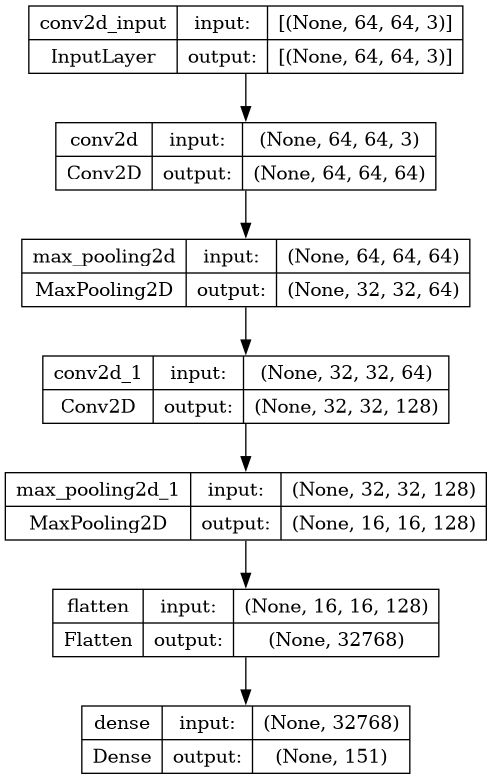

In [24]:
neuralnetwork_cnn1c = model_1c(img_size1, num_classes= 151)
neuralnetwork_cnn1c.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')

#models are all the same, plotting once
plot_model(neuralnetwork_cnn1c, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

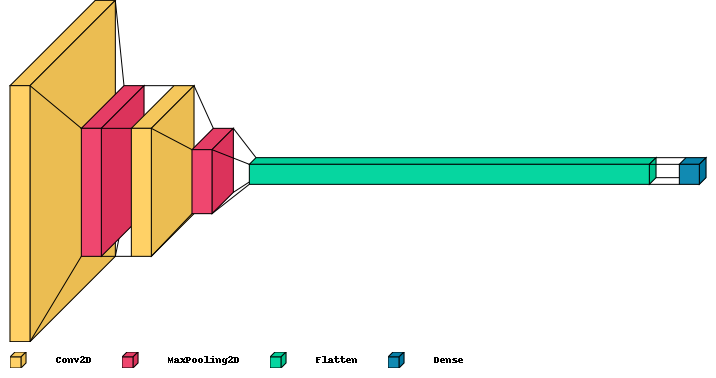

In [25]:
visualkeras.layered_view(neuralnetwork_cnn1c, legend = True, spacing = 30)

In [26]:
train_set1 , val_set1 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size1,
                                  num_batch= batch_siz1)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [27]:
hist1a , fil1a, es1a = train_model(model=neuralnetwork_cnn1a, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=11, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30


I0000 00:00:1707062281.826923      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - ETA: 0s - loss: 4.6528 - acc: 0.0672 - f1_m: 0.0108 - precision_m: 0.1189 - recall_m: 0.0057
Epoch 1: loss improved from inf to 4.65280, saving model to model11.h5
219/219 [==============================] - 107s 471ms/step - loss: 4.6528 - acc: 0.0672 - f1_m: 0.0108 - precision_m: 0.1189 - recall_m: 0.0057 - val_loss: 3.9815 - val_acc: 0.1589 - val_f1_m: 0.0227 - val_precision_m: 0.2829 - val_recall_m: 0.0119 - lr: 0.0020
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 3.7022 - acc: 0.2200 - f1_m: 0.1159 - precision_m: 0.5056 - recall_m: 0.0681
Epoch 2: loss improved from 4.65280 to 3.70216, saving model to model11.h5
219/219 [==============================] - 44s 202ms/step - loss: 3.7022 - acc: 0.2200 - f1_m: 0.1159 - precision_m: 0.5056 - recall_m: 0.0681 - val_loss: 2.9637 - val_acc: 0.3590 - val_f1_m: 0.2606 - val_precision_m: 0.7277 - val_recall_m: 0.1624 - lr: 0.0020
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 3.2741 - acc: 0.3437 - f1_m: 0.3109 - precision_m: 0.5892 - recall_m: 0.2162
Epoch 3: loss improved from 3.70216 to 3.27412, saving model to model11.h5
219/219 [==============================] - 44s 200ms/step - loss: 3.2741 - acc: 0.3437 - f1_m: 0.3109 - precision_m: 0.5892 - recall_m: 0.2162 - val_loss: 2.6249 - val_acc: 0.4364 - val_f1_m: 0.4021 - val_precision_m: 0.7557 - val_recall_m: 0.2784 - lr: 0.0020
Epoch 4/30
219/219 [=========================

In [28]:
hist1b , fil1b, es1b = train_model(model=neuralnetwork_cnn1b, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=12, 
                                num_epochs= 30) # meglio che arrivi a 30

Epoch 1/30


/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.4793 - acc: 0.0959 - f1_m: 0.0338 - precision_m: 0.2403 - recall_m: 0.0187
Epoch 1: loss improved from inf to 4.47928, saving model to model12.h5
219/219 [==============================] - 50s 225ms/step - loss: 4.4793 - acc: 0.0959 - f1_m: 0.0338 - precision_m: 0.2403 - recall_m: 0.0187 - val_loss: 3.5887 - val_acc: 0.2196 - val_f1_m: 0.1051 - val_precision_m: 0.4884 - val_recall_m: 0.0604 - lr: 0.0020
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 3.5713 - acc: 0.2798 - f1_m: 0.2104 - precision_m: 0.4987 - recall_m: 0.1378
Epoch 2: loss improved from 4.47928 to 3.57125, saving model to model12.h5
219/219 [==============================] - 49s 224ms/step - loss: 3.5713 - acc: 0.2798 - f1_m: 0.2104 - precision_m: 0.4987 - recall_m: 0.1378 - val_loss: 2.8330 - val_acc: 0.4214 - val_f1_m: 0.3718 - val_precision_m: 0.6447 - val_recall_m: 0.2648 - lr: 0.0020
Epoch 3/30
219/219 [=============================

In [29]:
hist1c , fil1c, es1c = train_model(model=neuralnetwork_cnn1c, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=13, 
                                num_epochs= 30) # meglio che arrivi a 30

Epoch 1/30


/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.0592 - acc: 0.1528 - f1_m: 0.0822 - precision_m: 0.3310 - recall_m: 0.0494
Epoch 1: loss improved from inf to 4.05919, saving model to model13.h5
219/219 [==============================] - 46s 201ms/step - loss: 4.0592 - acc: 0.1528 - f1_m: 0.0822 - precision_m: 0.3310 - recall_m: 0.0494 - val_loss: 2.9646 - val_acc: 0.3540 - val_f1_m: 0.3037 - val_precision_m: 0.5880 - val_recall_m: 0.2076 - lr: 0.0020
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 3.2501 - acc: 0.3706 - f1_m: 0.3440 - precision_m: 0.5483 - recall_m: 0.2551
Epoch 2: loss improved from 4.05919 to 3.25015, saving model to model13.h5
219/219 [==============================] - 43s 199ms/step - loss: 3.2501 - acc: 0.3706 - f1_m: 0.3440 - precision_m: 0.5483 - recall_m: 0.2551 - val_loss: 2.6102 - val_acc: 0.4688 - val_f1_m: 0.4563 - val_precision_m: 0.6458 - val_recall_m: 0.3573 - lr: 0.0020
Epoch 3/30
219/219 [=============================

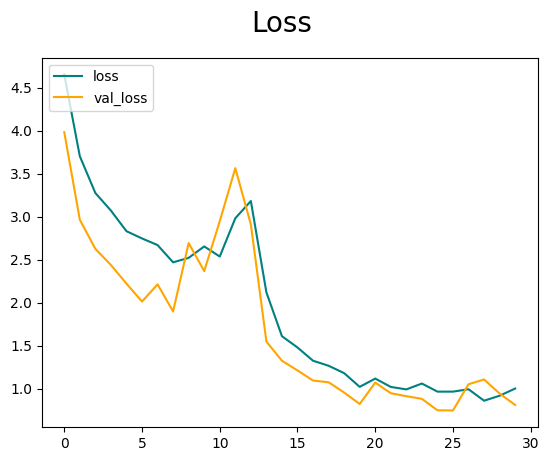

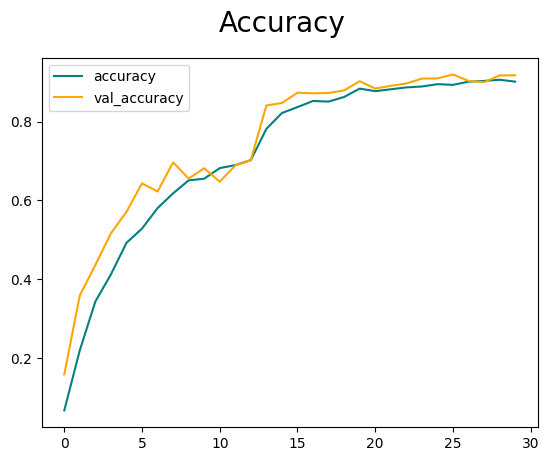

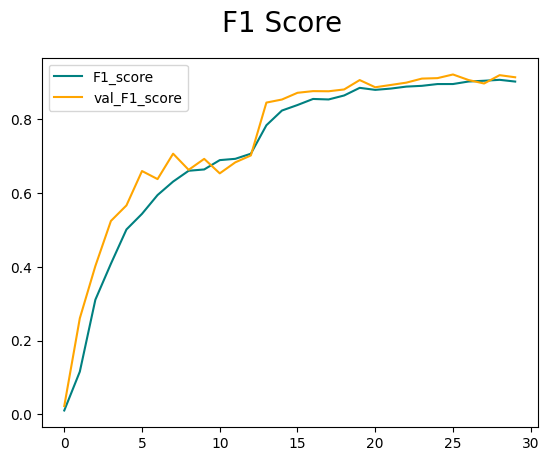

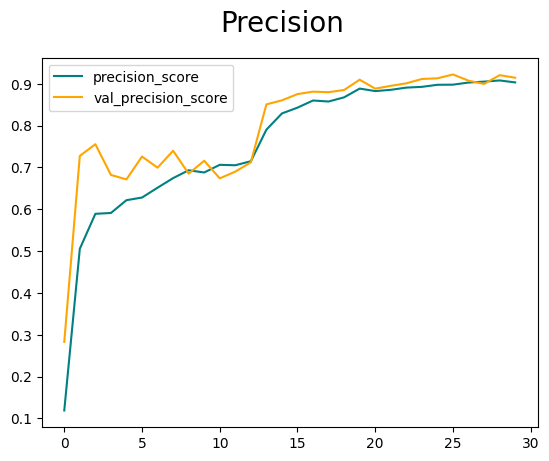

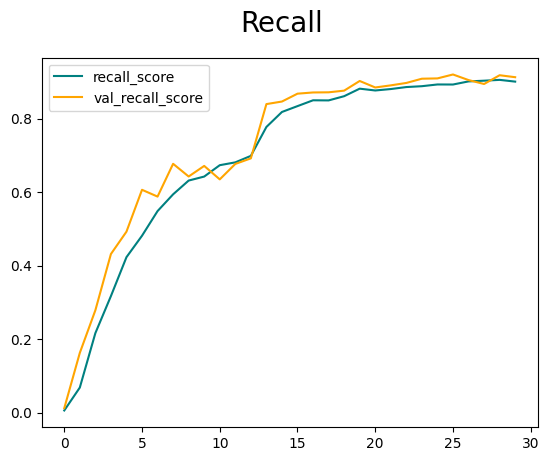

In [30]:
plot_history(hist=hist1a)

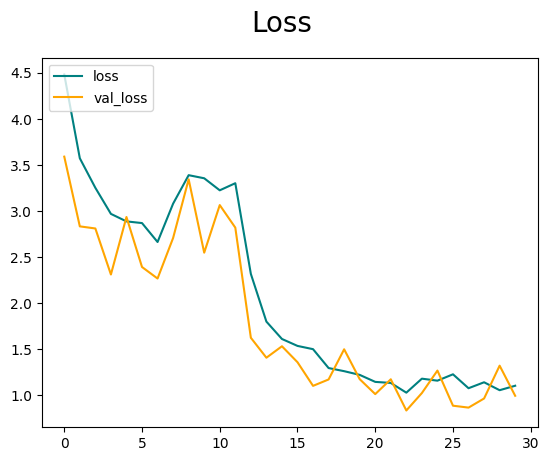

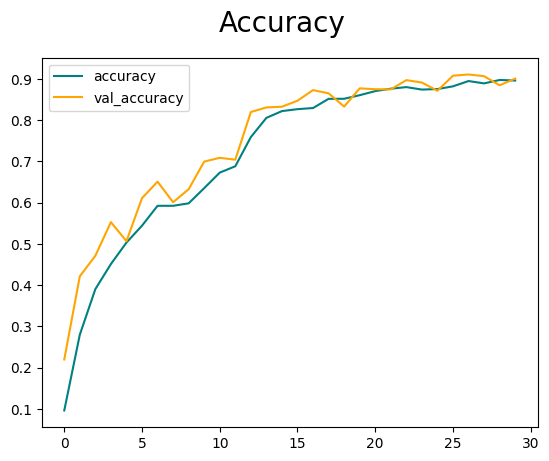

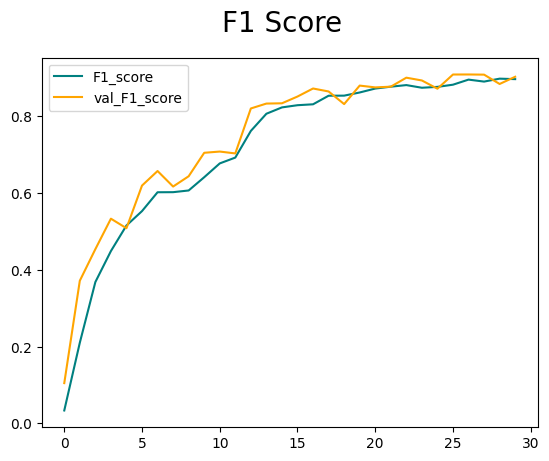

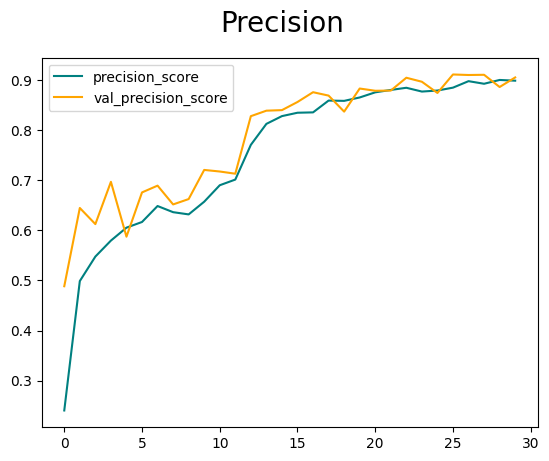

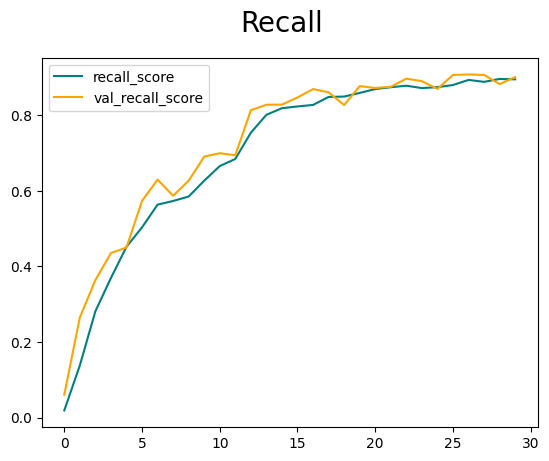

In [31]:
plot_history(hist=hist1b)

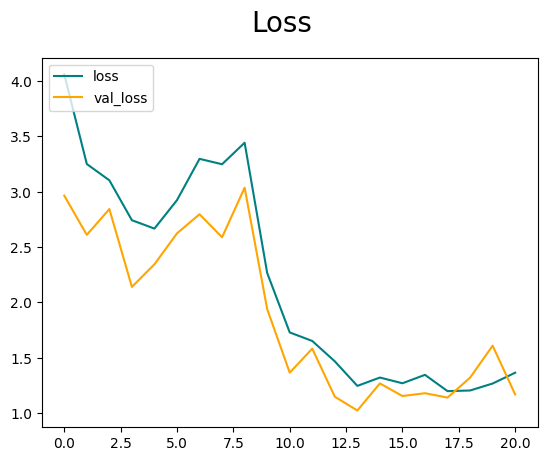

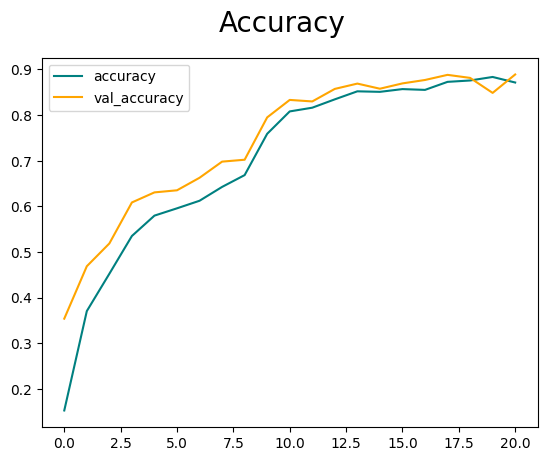

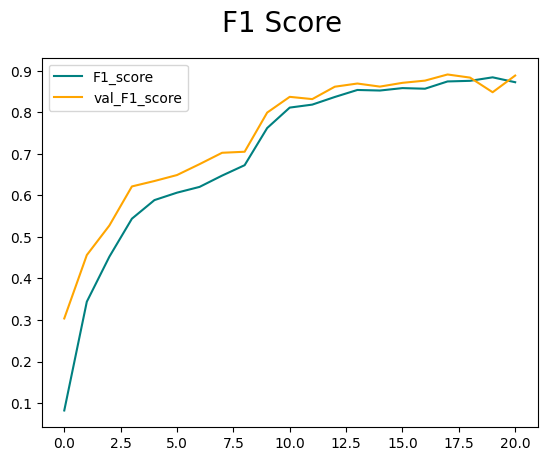

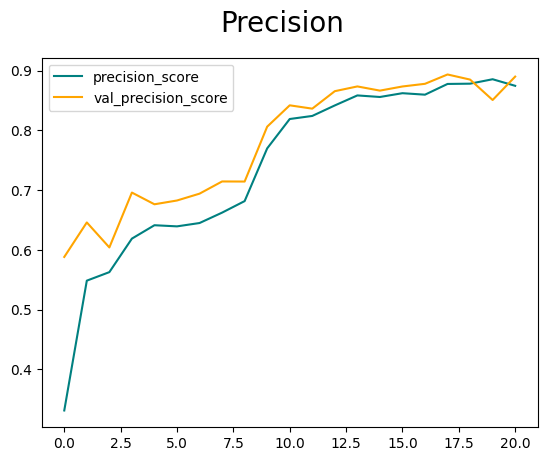

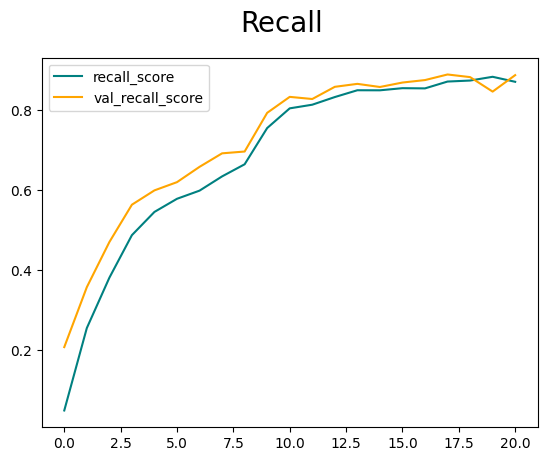

In [32]:
plot_history(hist=hist1c)

## Training Model 2

In [33]:
img_size2 = (64, 64, 3)
batch_siz2 = 32
num_classes = 151

In [34]:
train_set2 , val_set2 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size2,
                                num_batch= batch_siz2)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

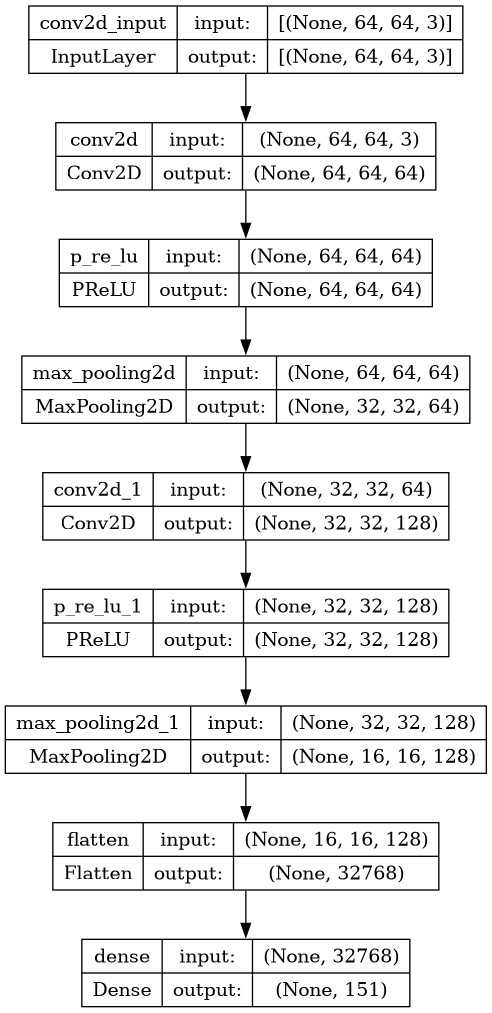

In [35]:
neuralnetwork_cnn2a = model_2a(img_size2, num_classes= 151)
neuralnetwork_cnn2a.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn2a, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [36]:
neuralnetwork_cnn2b = model_2b(img_size2, num_classes= 151)
neuralnetwork_cnn2b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [37]:
neuralnetwork_cnn2c = model_2c(img_size2, num_classes= 151)
neuralnetwork_cnn2c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [38]:
hist2a , fil2a, es2a = train_model(model=neuralnetwork_cnn2a, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=21, 
                                num_epochs=30)

Epoch 1/30


/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.8367 - acc: 0.0269 - f1_m: 2.6860e-04 - precision_m: 0.0023 - recall_m: 1.4269e-04
Epoch 1: loss improved from inf to 4.83674, saving model to model21.h5
219/219 [==============================] - 46s 202ms/step - loss: 4.8367 - acc: 0.0269 - f1_m: 2.6860e-04 - precision_m: 0.0023 - recall_m: 1.4269e-04 - val_loss: 3.9990 - val_acc: 0.1186 - val_f1_m: 0.0064 - val_precision_m: 0.1053 - val_recall_m: 0.0033 - lr: 0.0020
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 3.5037 - acc: 0.1961 - f1_m: 0.0715 - precision_m: 0.5285 - recall_m: 0.0397
Epoch 2: loss improved from 4.83674 to 3.50366, saving model to model21.h5
219/219 [==============================] - 44s 200ms/step - loss: 3.5037 - acc: 0.1961 - f1_m: 0.0715 - precision_m: 0.5285 - recall_m: 0.0397 - val_loss: 2.8114 - val_acc: 0.3257 - val_f1_m: 0.1870 - val_precision_m: 0.7313 - val_recall_m: 0.1102 - lr: 0.0020
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 2.5704 - acc: 0.3707 - f1_m: 0.2705 - precision_m: 0.7105 - recall_m: 0.1714
Epoch 3: loss improved from 3.50366 to 2.57043, saving model to model21.h5
219/219 [==============================] - 48s 219ms/step - loss: 2.5704 - acc: 0.3707 - f1_m: 0.2705 - precision_m: 0.7105 - recall_m: 0.1714 - val_loss: 2.1028 - val_acc: 0.4734 - val_f1_m: 0.3864 - val_precision_m: 0.7918 - val_recall_m: 0.2607 - lr: 0.0020
Epoch 4/30
219/219 [=========================

In [39]:
hist2b , fil2b, es2b = train_model(model=neuralnetwork_cnn2b, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=22, 
                                num_epochs=30)

Epoch 1/30


/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.7424 - acc: 0.0362 - f1_m: 0.0027 - precision_m: 0.0297 - recall_m: 0.0014
Epoch 1: loss improved from inf to 4.74239, saving model to model22.h5
219/219 [==============================] - 55s 243ms/step - loss: 4.7424 - acc: 0.0362 - f1_m: 0.0027 - precision_m: 0.0297 - recall_m: 0.0014 - val_loss: 3.7852 - val_acc: 0.1601 - val_f1_m: 0.0288 - val_precision_m: 0.3070 - val_recall_m: 0.0156 - lr: 0.0020
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 3.1066 - acc: 0.2676 - f1_m: 0.1542 - precision_m: 0.6461 - recall_m: 0.0909
Epoch 2: loss improved from 4.74239 to 3.10664, saving model to model22.h5
219/219 [==============================] - 45s 206ms/step - loss: 3.1066 - acc: 0.2676 - f1_m: 0.1542 - precision_m: 0.6461 - recall_m: 0.0909 - val_loss: 2.4019 - val_acc: 0.4230 - val_f1_m: 0.3021 - val_precision_m: 0.7999 - val_recall_m: 0.1891 - lr: 0.0020
Epoch 3/30
219/219 [=============================

In [40]:
hist2c , fil2c, es2c = train_model(model=neuralnetwork_cnn2c, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=23, 
                                num_epochs=30)

/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 4.2511 - acc: 0.0969 - f1_m: 0.0241 - precision_m: 0.1906 - recall_m: 0.0131
Epoch 1: loss improved from inf to 4.25107, saving model to model23.h5
219/219 [==============================] - 47s 204ms/step - loss: 4.2511 - acc: 0.0969 - f1_m: 0.0241 - precision_m: 0.1906 - recall_m: 0.0131 - val_loss: 3.1055 - val_acc: 0.2675 - val_f1_m: 0.0972 - val_precision_m: 0.6580 - val_recall_m: 0.0535 - lr: 0.0020
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 2.7242 - acc: 0.3425 - f1_m: 0.2351 - precision_m: 0.7228 - recall_m: 0.1447
Epoch 2: loss improved from 4.25107 to 2.72421, saving model to model23.h5
219/219 [==============================] - 46s 208ms/step - loss: 2.7242 - acc: 0.3425 - f1_m: 0.2351 - precision_m: 0.7228 - recall_m: 0.1447 - val_loss: 2.1429 - val_acc: 0.4713 - val_f1_m: 0.3728 - val_precision_m: 0.7941 - val_recall_m: 0.2475 - lr: 0.0020
Epoch 3/30
219/219 [==================

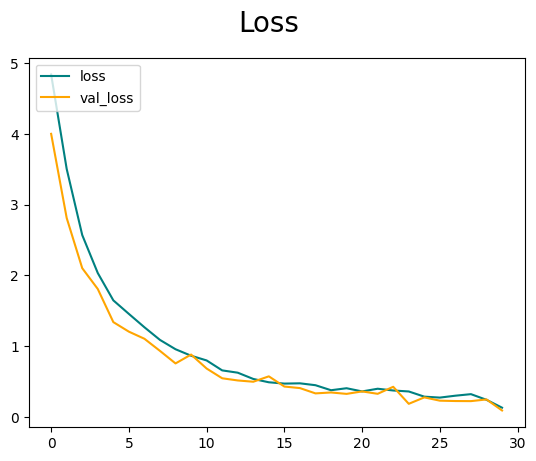

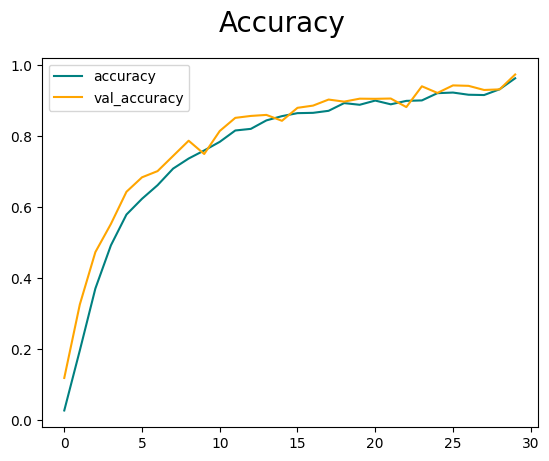

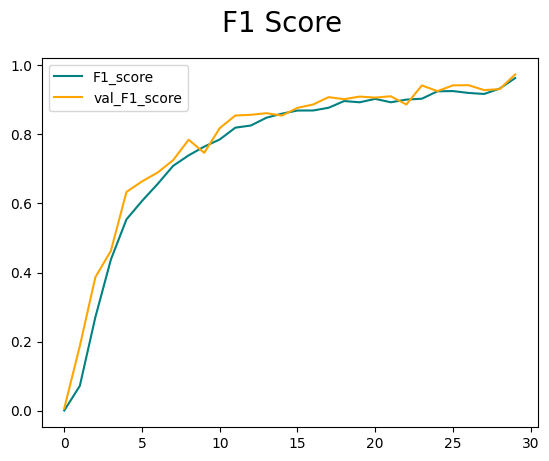

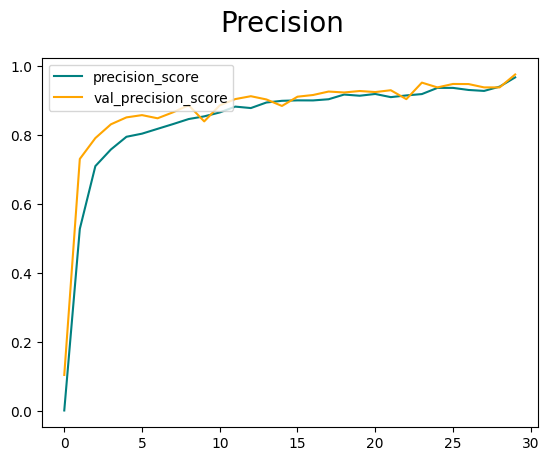

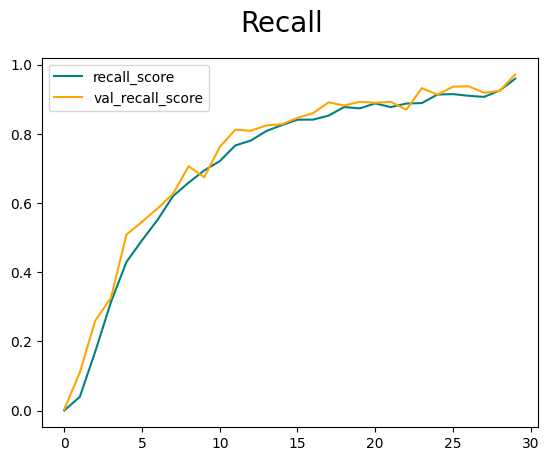

In [41]:
plot_history(hist=hist2a)

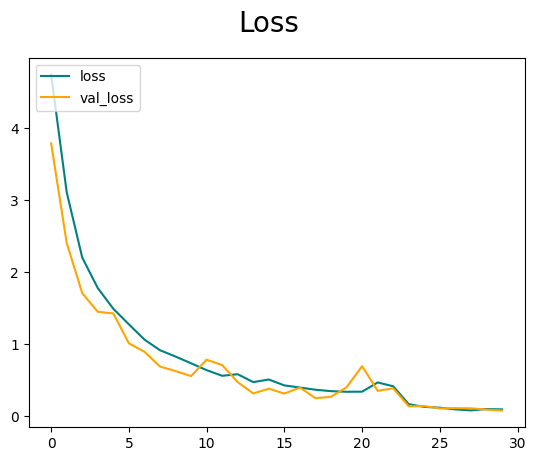

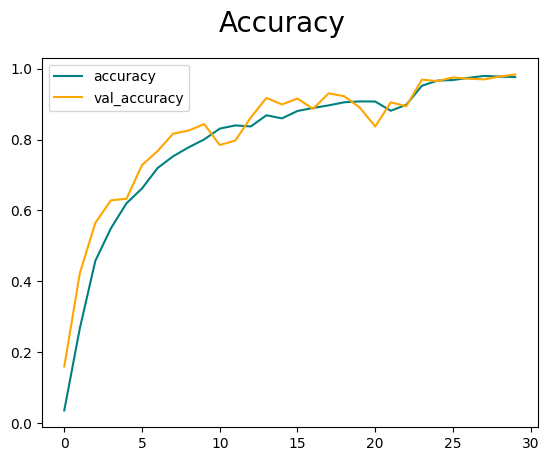

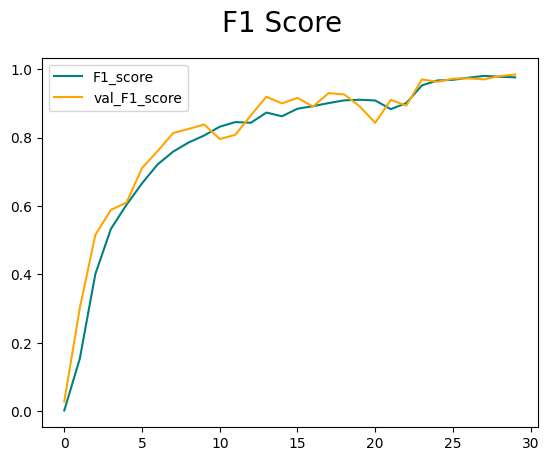

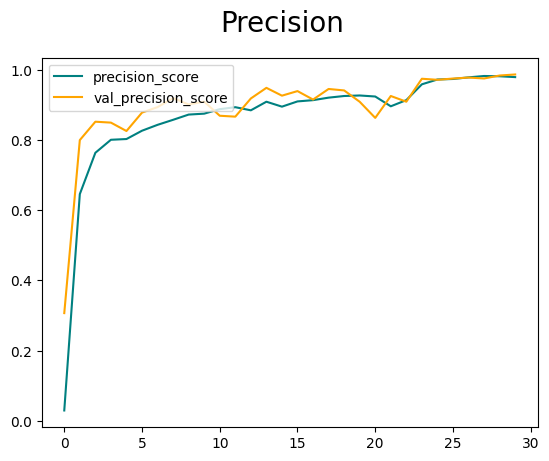

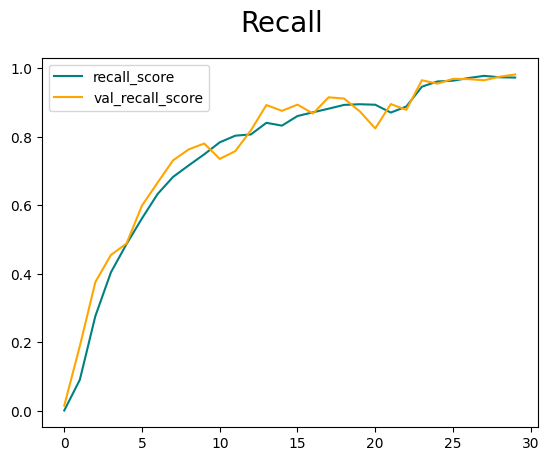

In [42]:
plot_history(hist=hist2b)

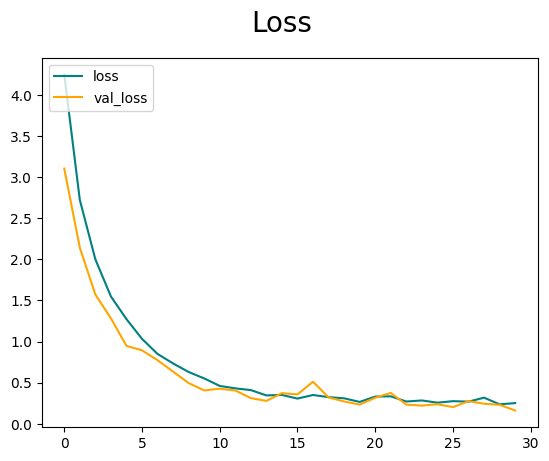

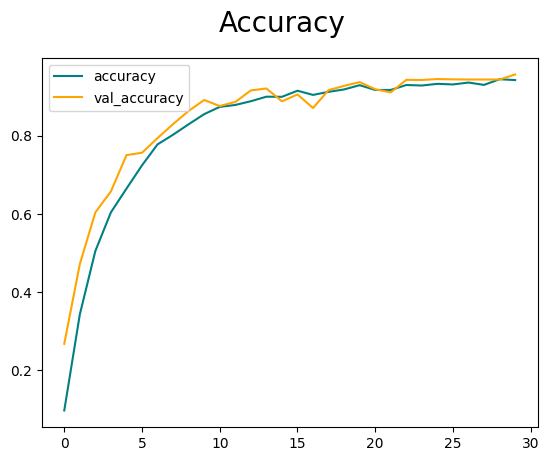

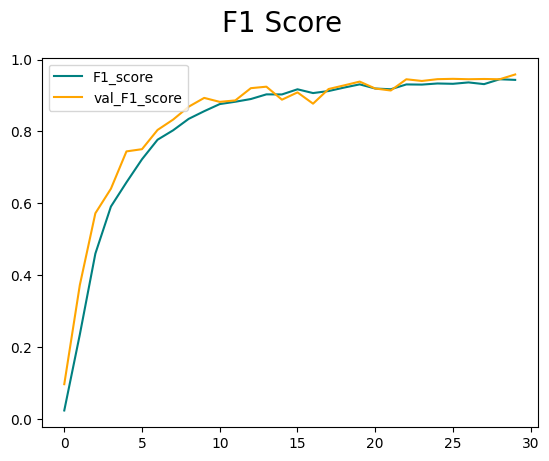

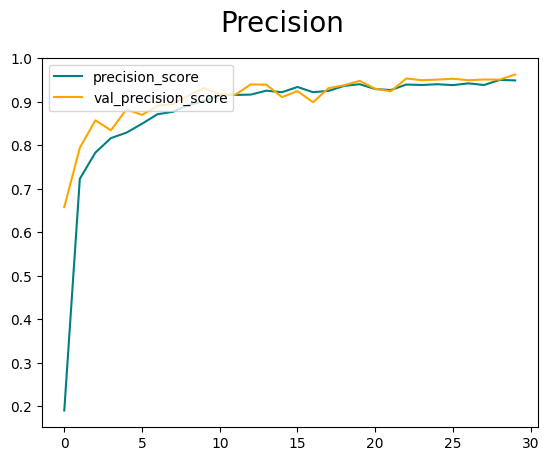

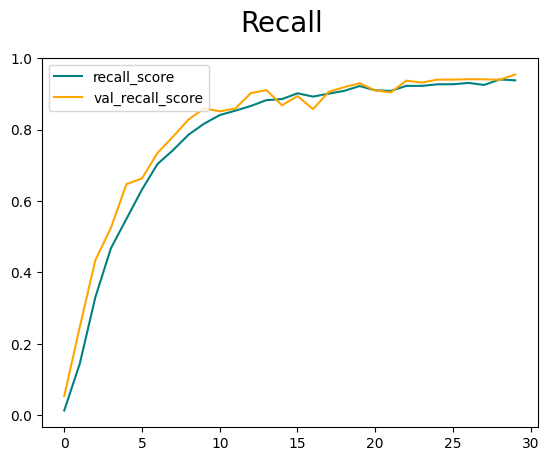

In [43]:
plot_history(hist=hist2c)

## Training Model 3

In [44]:
img_size3= (64, 64, 3)
batch_siz3 = 32
num_classes = 151

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

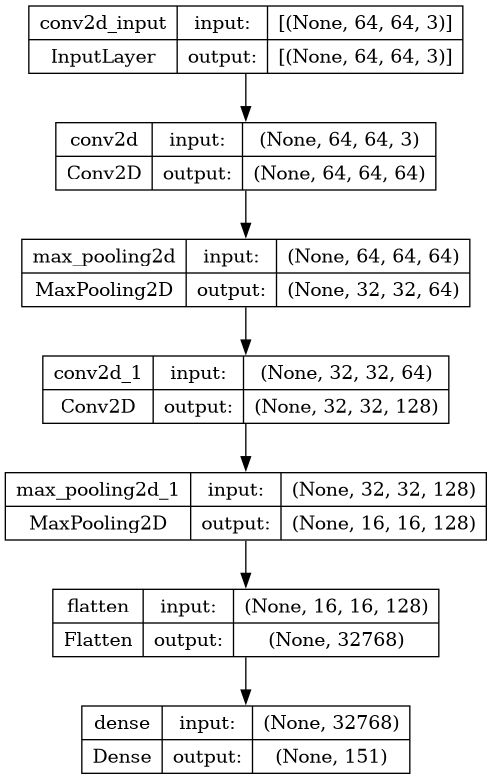

In [45]:
neuralnetwork_cnn3a = model_3a(img_size3, num_classes= 151)
neuralnetwork_cnn3a.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn3a, to_file='model_plot4.png', show_shapes=True, show_layer_names=True)

In [46]:
neuralnetwork_cnn3b = model_3b(img_size3, num_classes= 151)
neuralnetwork_cnn3b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [47]:
neuralnetwork_cnn3c = model_3c(img_size3, num_classes= 151)
neuralnetwork_cnn3c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [48]:
train_set3 , val_set3 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size3,
                                  num_batch= batch_siz3)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [49]:
hist3a , fil3a, es3a = train_model(model=neuralnetwork_cnn3a, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=31, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 3.9988 - acc: 0.1608 - f1_m: 0.0784 - precision_m: 0.3874 - recall_m: 0.0453
Epoch 1: loss improved from inf to 3.99878, saving model to model31.h5
219/219 [==============================] - 48s 212ms/step - loss: 3.9988 - acc: 0.1608 - f1_m: 0.0784 - precision_m: 0.3874 - recall_m: 0.0453 - val_loss: 2.9123 - val_acc: 0.3374 - val_f1_m: 0.2186 - val_precision_m: 0.6865 - val_recall_m: 0.1324 - lr: 0.0020
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.8530 - acc: 0.3658 - f1_m: 0.3105 - precision_m: 0.6713 - recall_m: 0.2058
Epoch 2: loss improved from 3.99878 to 2.85301, saving model to model31.h5
219/219 [==============================] - 46s 211ms/step - loss: 2.8530 - acc: 0.3658 - f1_m: 0.3105 - precision_m: 0.6713 - recall_m: 0.2058 - val_loss: 2.3010 - val_acc: 0.4663 - val_f1_m: 0.4125 - val_precision_m: 0.7481 - val_recall_m: 0.2887 - lr: 0.0020
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 2.2461 - acc: 0.4836 - f1_m: 0.4665 - precision_m: 0.7294 - recall_m: 0.3472
Epoch 3: loss improved from 2.85301 to 2.24611, saving model to model31.h5
219/219 [==============================] - 48s 220ms/step - loss: 2.2461 - acc: 0.4836 - f1_m: 0.4665 - precision_m: 0.7294 - recall_m: 0.3472 - val_loss: 1.7932 - val_acc: 0.5628 - val_f1_m: 0.5513 - val_precision_m: 0.7999 - val_recall_m: 0.4239 - lr: 0.0020
Epoch 4/30
219/219 [=========================

In [50]:
hist3b , fil3b, es3b = train_model(model=neuralnetwork_cnn3b, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=32, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 3.9443 - acc: 0.1647 - f1_m: 0.0869 - precision_m: 0.3981 - recall_m: 0.0504
Epoch 1: loss improved from inf to 3.94426, saving model to model32.h5
219/219 [==============================] - 48s 212ms/step - loss: 3.9443 - acc: 0.1647 - f1_m: 0.0869 - precision_m: 0.3981 - recall_m: 0.0504 - val_loss: 2.7677 - val_acc: 0.3694 - val_f1_m: 0.2982 - val_precision_m: 0.7206 - val_recall_m: 0.1904 - lr: 0.0020
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 2.7660 - acc: 0.3730 - f1_m: 0.3273 - precision_m: 0.6579 - recall_m: 0.2216
Epoch 2: loss improved from 3.94426 to 2.76599, saving model to model32.h5
219/219 [==============================] - 46s 208ms/step - loss: 2.7660 - acc: 0.3730 - f1_m: 0.3273 - precision_m: 0.6579 - recall_m: 0.2216 - val_loss: 2.2866 - val_acc: 0.4626 - val_f1_m: 0.4197 - val_precision_m: 0.7363 - val_recall_m: 0.2969 - lr: 0.0020
Epoch 3/30
219/219 [==================

In [51]:
hist3c , fil3c, es3c = train_model(model=neuralnetwork_cnn3c, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=33, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_27/2170111214.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 3.7622 - acc: 0.1957 - f1_m: 0.1078 - precision_m: 0.4670 - recall_m: 0.0633
Epoch 1: loss improved from inf to 3.76216, saving model to model33.h5
219/219 [==============================] - 56s 250ms/step - loss: 3.7622 - acc: 0.1957 - f1_m: 0.1078 - precision_m: 0.4670 - recall_m: 0.0633 - val_loss: 2.6583 - val_acc: 0.3856 - val_f1_m: 0.2773 - val_precision_m: 0.7556 - val_recall_m: 0.1731 - lr: 0.0020
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 2.5259 - acc: 0.4246 - f1_m: 0.3650 - precision_m: 0.7136 - recall_m: 0.2489
Epoch 2: loss improved from 3.76216 to 2.52588, saving model to model33.h5
219/219 [==============================] - 45s 204ms/step - loss: 2.5259 - acc: 0.4246 - f1_m: 0.3650 - precision_m: 0.7136 - recall_m: 0.2489 - val_loss: 1.9075 - val_acc: 0.5491 - val_f1_m: 0.5061 - val_precision_m: 0.8148 - val_recall_m: 0.3717 - lr: 0.0020
Epoch 3/30
219/219 [==================

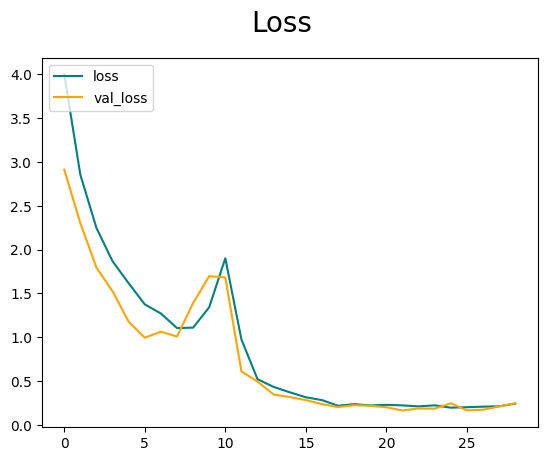

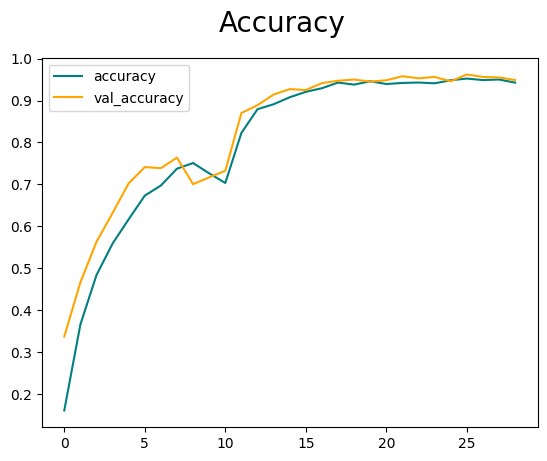

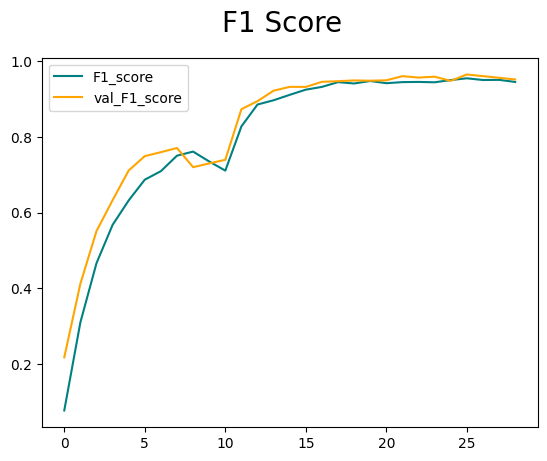

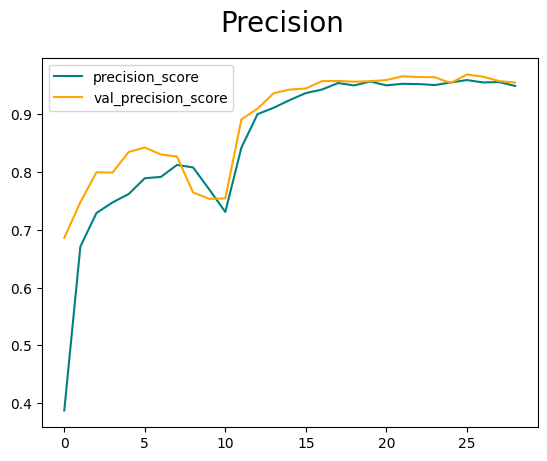

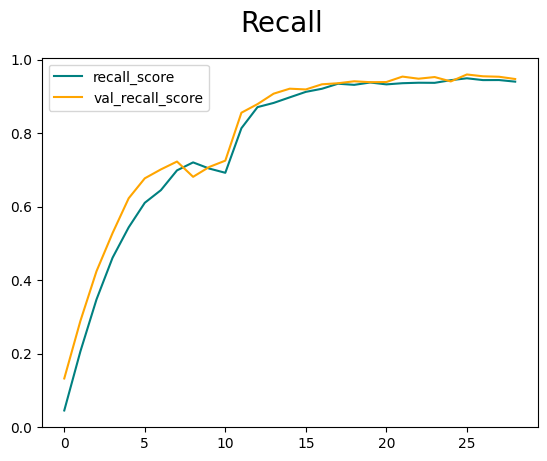

In [52]:
plot_history(hist=hist3a)

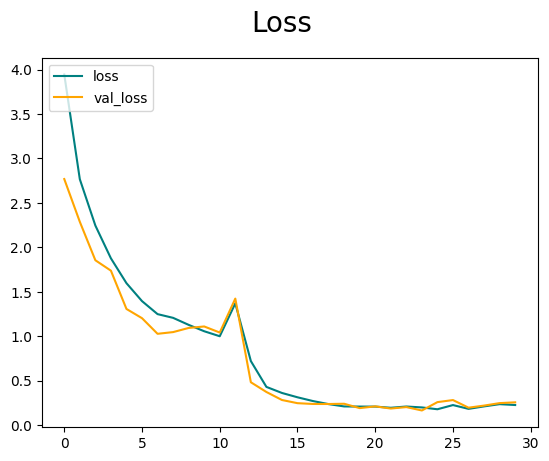

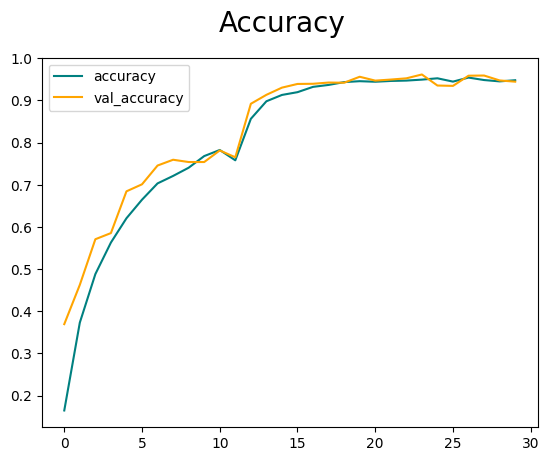

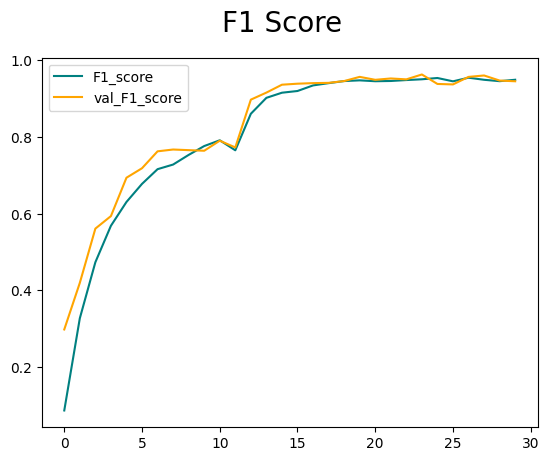

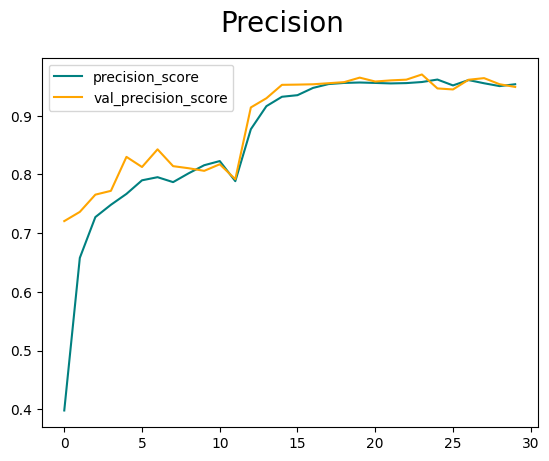

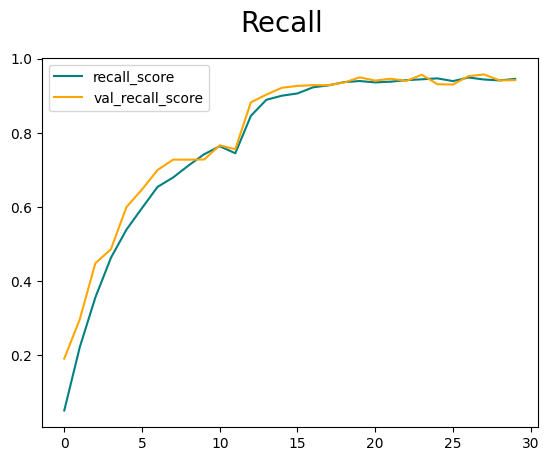

In [53]:
plot_history(hist=hist3b)

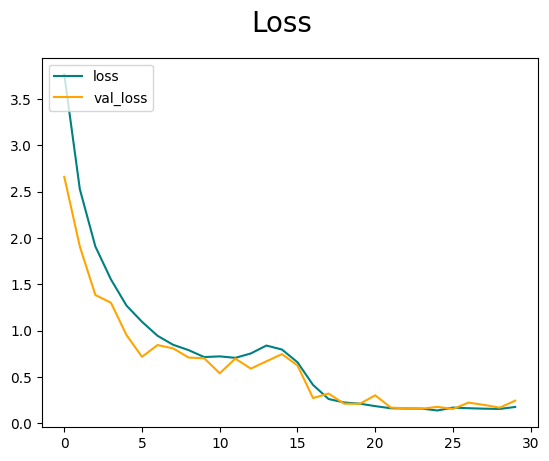

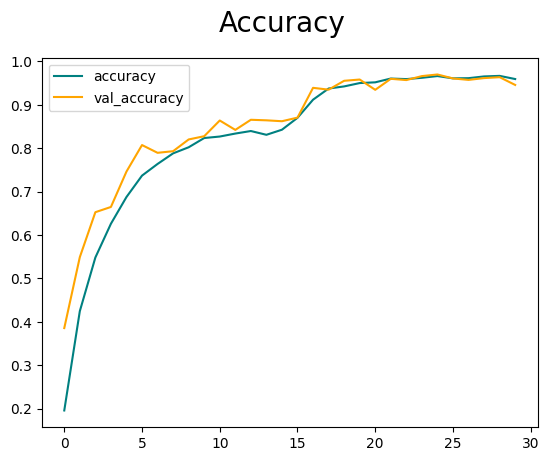

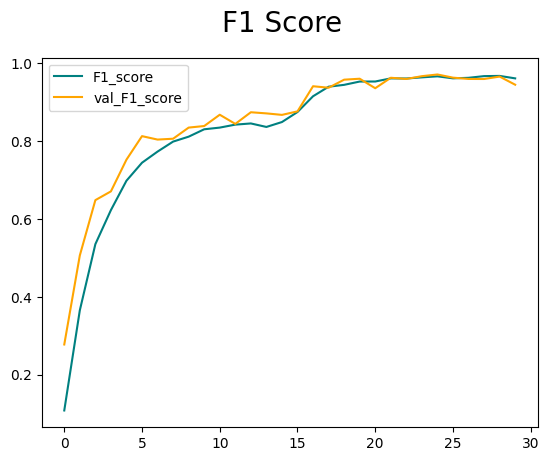

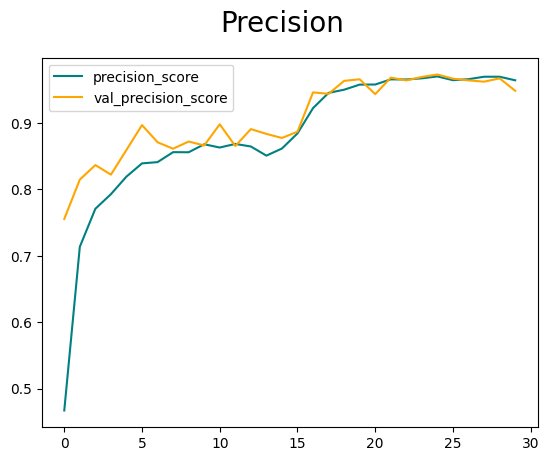

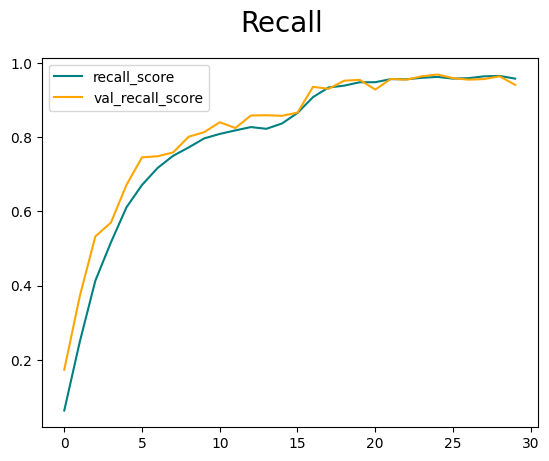

In [54]:
plot_history(hist=hist3c)